# Experimento 3 - Comparação com ReAct com Prompt Enriquecido (Factual Direta)

**Objetivo**: Avaliar se a separação explícita da etapa de personalização, proposta no \textit{PersonaReAct}, resulta em respostas mais organizadas, concisas e claras do que a personalização direta por prompt no ReAct tradicional.

**Metodologia**
* Escolher 4 perfis diferentes
* Escolher 1 pergunta para todos os perfis
  * "Qual jogador percorreu mais metros em alta intensidade?"
  * Para cada perfil, responder a pergunta com o ReAct com Prompt Enriquecido e com o PersonaReAct
* Submeter o par de respostas (com ReAct com Prompt Enriquecido e com o PersonaReAct) à LLM avaliadora.

Critérios de avaliação da LLM:
*  Tom Adequado ao Perfil,
*  Quantidade de Informações para o Perfil,
*  Personalização Perceptível.

Cada critério foi aplicado 20 vezes para cada resposta e uma média foi calculada.

# Importação de bibliotecas

In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Importação dos Resultados

O arquivo de resultados é composto pelas pontuações (scores) geradas pelo G-Eval para cada um dos 3 critérios elaborados.

A pergunta foi feita utilizando o padrão ReAct e o padrão PersonaReAct para cada perfil listado abaixo.

Cada pontuação foi calculada 20 vezes e os seus resultados salvos nas listas ```scores_personareact``` e ```scores_react_prompt```.

## Torcedor

Pergunta: "Qual jogador mais se destacou em termos de distância percorrida e velocidade média no jogo contra o Ceará no dia 1º de abril de 2023?"

Respostas:
*  **ReAct**: *"No jogo contra o Ceará no dia 1º de abril de 2023, Bruno Pacheco teve uma velocidade média de 1.36 m/s, mostrando sua dedicação e esforço em campo para ajudar o nosso time!"*

*  **PersonaReAct**: *"A velocidade média do Bruno Pacheco no jogo contra o Ceará, realizado no dia 1º de abril de 2023, foi de 1.36 m/s. Esse dado é importante, pois demonstra o empenho e a performance do jogador em campo, refletindo seu envolvimento na partida e como isso pode impactar o desempenho da nossa equipe. Fica a expectativa para ver mais performances como esta nas próximas partidas!"*


In [21]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_torcedor.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,O Bruno Pacheco correu bem naquele jogo contra...,Torcedor do Time,Personalização Perceptível,9.79,3.43,6.36
1,O Bruno Pacheco correu bem naquele jogo contra...,Torcedor do Time,Personalização Perceptível,9.76,3.40,6.36
2,O Bruno Pacheco correu bem naquele jogo contra...,Torcedor do Time,Personalização Perceptível,9.81,3.43,6.38
3,O Bruno Pacheco correu bem naquele jogo contra...,Torcedor do Time,Personalização Perceptível,9.81,3.38,6.43
4,O Bruno Pacheco correu bem naquele jogo contra...,Torcedor do Time,Personalização Perceptível,9.77,3.42,6.35


In [22]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,Alinhamento com Preferências do Perfil,9.43,0.15,5.35,0.47
1,Consistência da Personalização,9.44,0.03,2.95,0.11
2,Personalização Perceptível,9.79,0.03,3.68,0.42


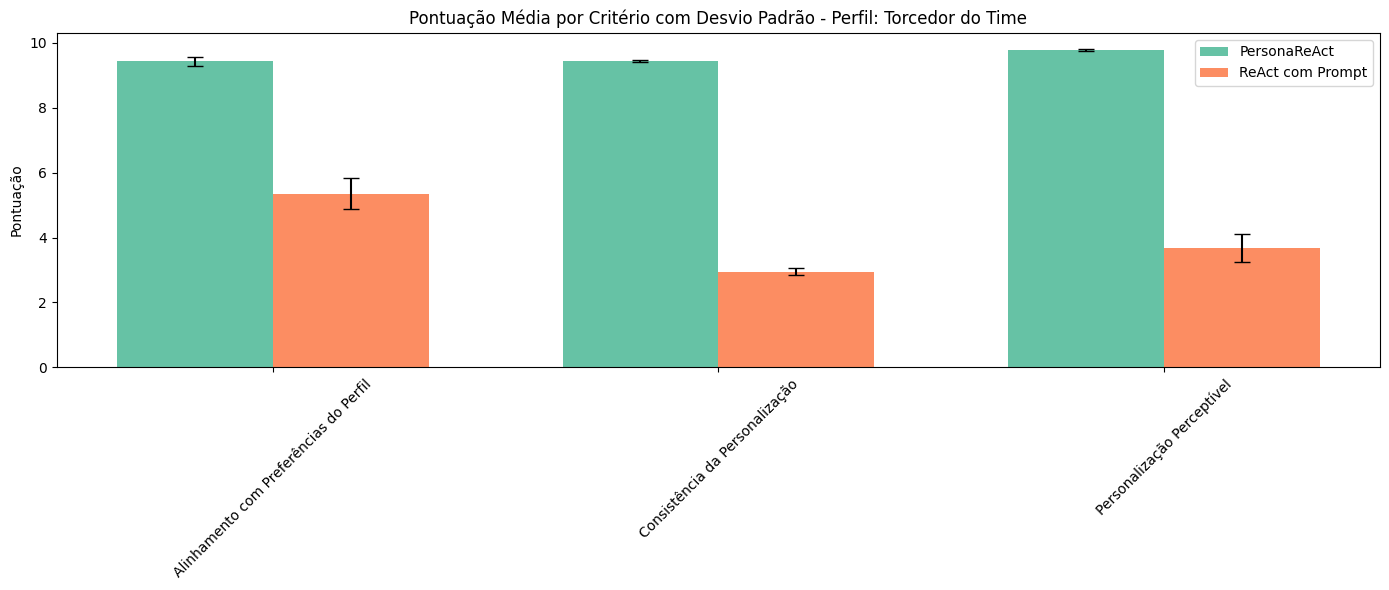

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Torcedor do Time")
ax.legend()
plt.tight_layout()
plt.show()

In [24]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,Personalização Perceptível,9.79,3.68,1.530150e-23,✅
1,Alinhamento com Preferências do Perfil,9.43,5.35,8.583697e-19,✅
2,Consistência da Personalização,9.44,2.95,1.149762e-35,✅


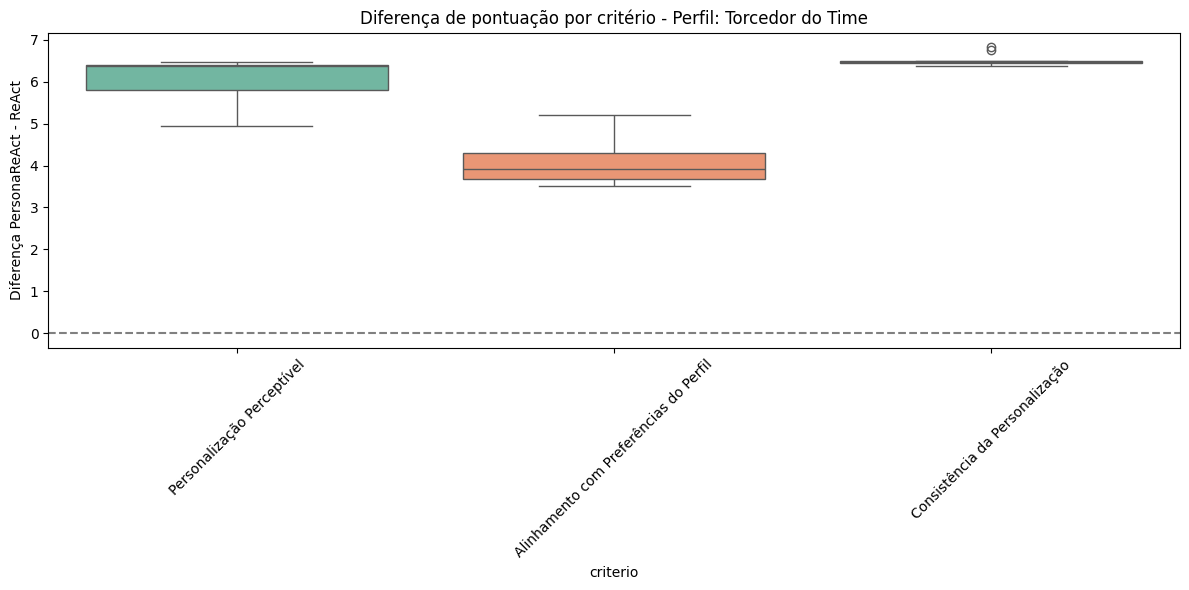

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Torcedor do Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

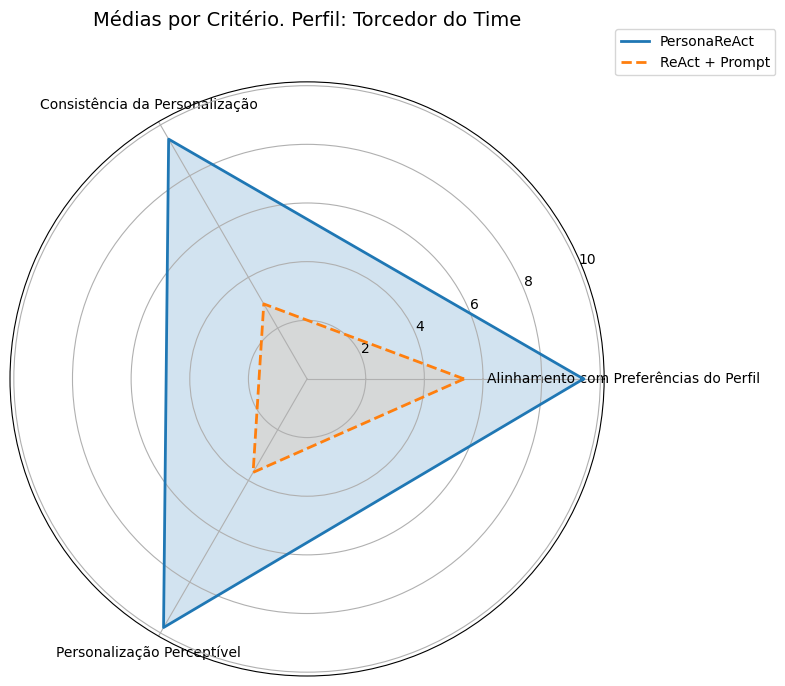

In [26]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Torcedor do Time", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## Técnico do Time

In [27]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_tecnico.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Qual foi a velocidade média registrada por Bru...,Técnico do Time,Personalização Perceptível,8.11,7.39,0.72
1,Qual foi a velocidade média registrada por Bru...,Técnico do Time,Personalização Perceptível,8.02,7.55,0.47
2,Qual foi a velocidade média registrada por Bru...,Técnico do Time,Personalização Perceptível,7.97,7.54,0.43
3,Qual foi a velocidade média registrada por Bru...,Técnico do Time,Personalização Perceptível,8.06,7.62,0.44
4,Qual foi a velocidade média registrada por Bru...,Técnico do Time,Personalização Perceptível,8.10,7.54,0.56


In [28]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,Alinhamento com Preferências do Perfil,9.43,0.14,8.60,0.10
1,Consistência da Personalização,3.80,0.16,2.73,0.24
2,Personalização Perceptível,8.08,0.06,7.50,0.06


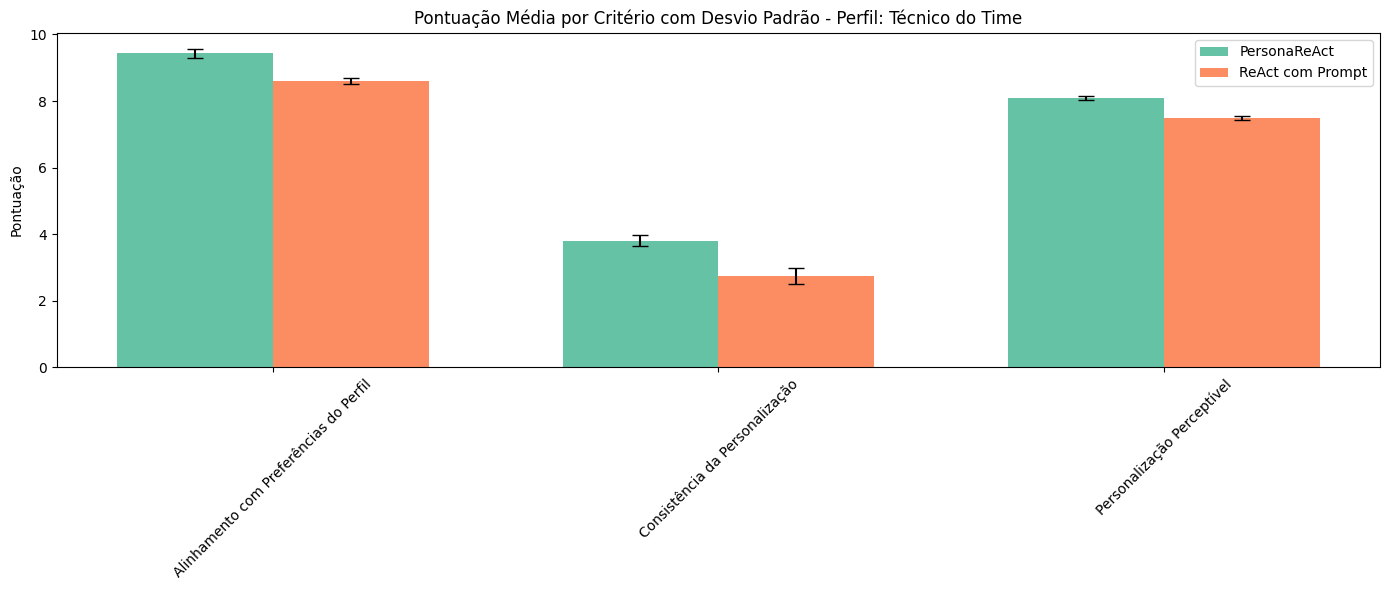

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Técnico do Time")
ax.legend()
plt.tight_layout()
plt.show()

In [30]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,Personalização Perceptível,8.08,7.50,1.364463e-16,✅
1,Alinhamento com Preferências do Perfil,9.43,8.60,5.152261e-15,✅
2,Consistência da Personalização,3.80,2.73,1.361304e-12,✅


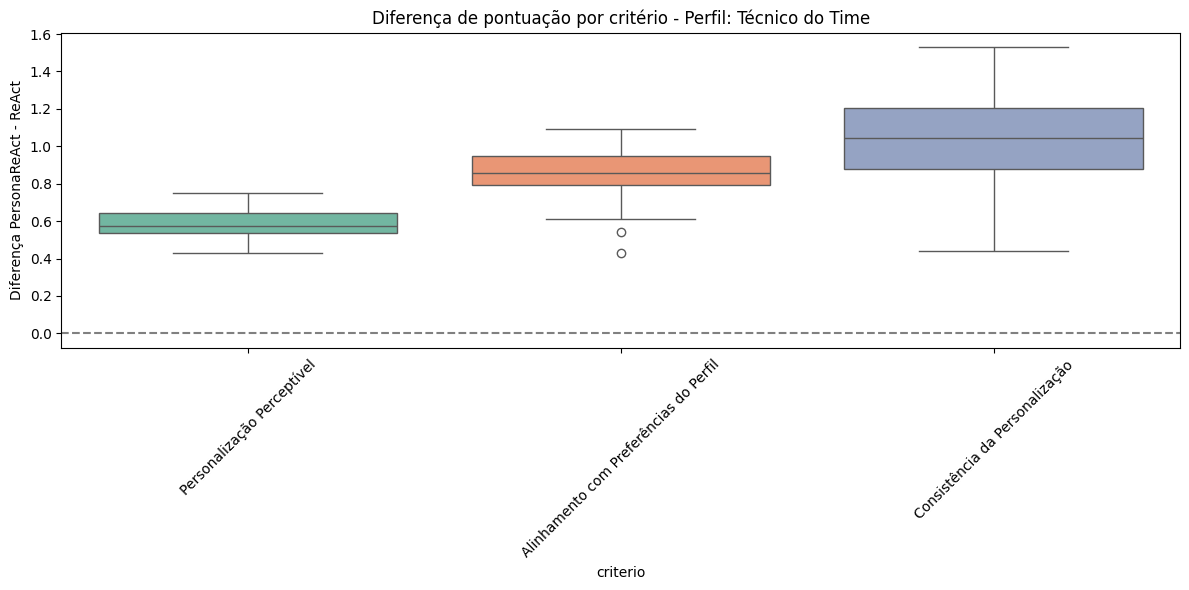

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Técnico do Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

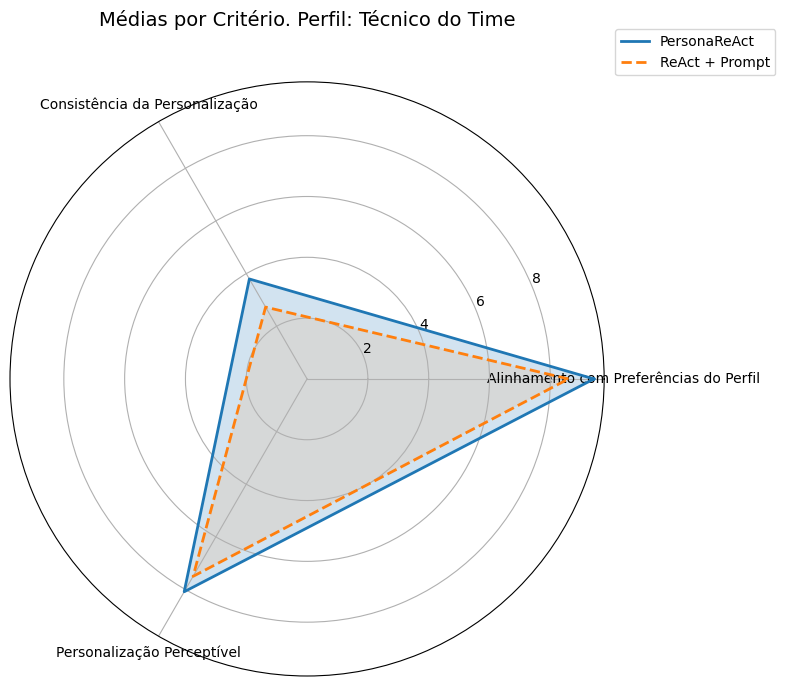

In [32]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Técnico do Time", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## Narrador de Jogo de Futebol

In [33]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_narrador.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Torcedor ligado na nossa transmissão quer sabe...,Narrador de Jogo de Futebol,Personalização Perceptível,7.32,3.19,4.13
1,Torcedor ligado na nossa transmissão quer sabe...,Narrador de Jogo de Futebol,Personalização Perceptível,7.33,3.17,4.16
2,Torcedor ligado na nossa transmissão quer sabe...,Narrador de Jogo de Futebol,Personalização Perceptível,7.23,3.23,4.00
3,Torcedor ligado na nossa transmissão quer sabe...,Narrador de Jogo de Futebol,Personalização Perceptível,7.33,3.26,4.07
4,Torcedor ligado na nossa transmissão quer sabe...,Narrador de Jogo de Futebol,Personalização Perceptível,7.28,3.19,4.09


In [34]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,Alinhamento com Preferências do Perfil,3.95,0.23,2.59,0.09
1,Consistência da Personalização,6.19,0.33,2.02,0.11
2,Personalização Perceptível,7.28,0.08,3.12,0.21


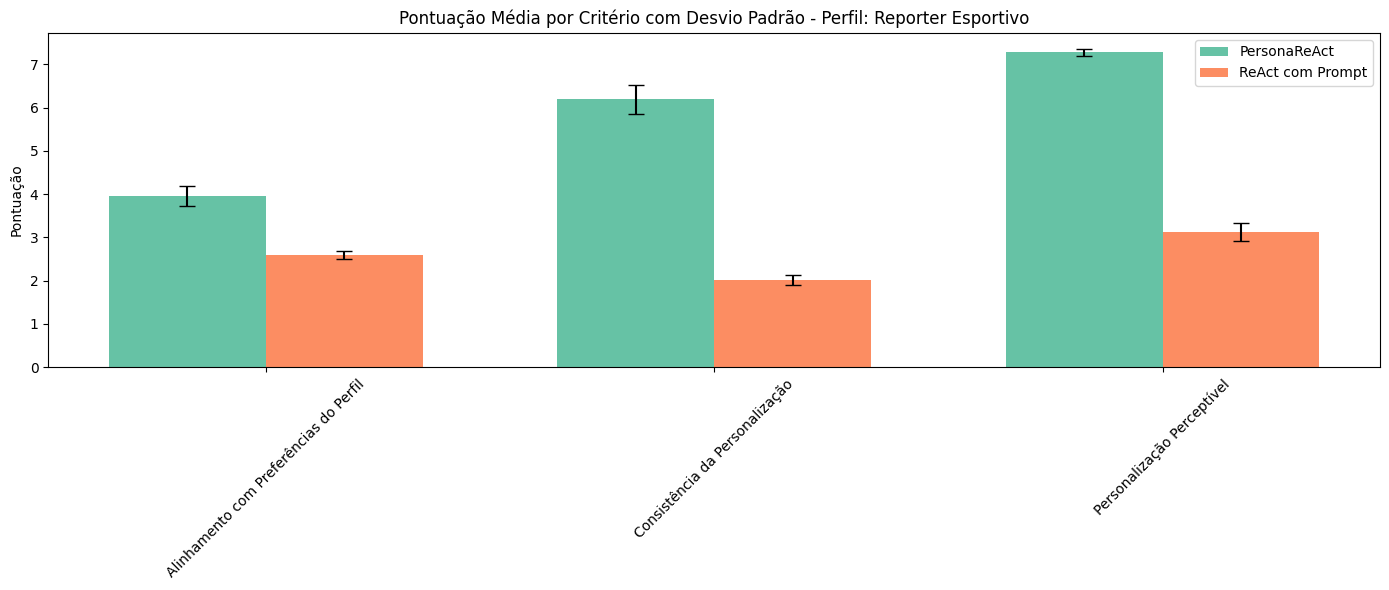

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Reporter Esportivo")
ax.legend()
plt.tight_layout()
plt.show()

In [36]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,Personalização Perceptível,7.28,3.12,3.538789e-26,✅
1,Alinhamento com Preferências do Perfil,3.95,2.59,2.982262e-15,✅
2,Consistência da Personalização,6.19,2.02,6.797621e-23,✅


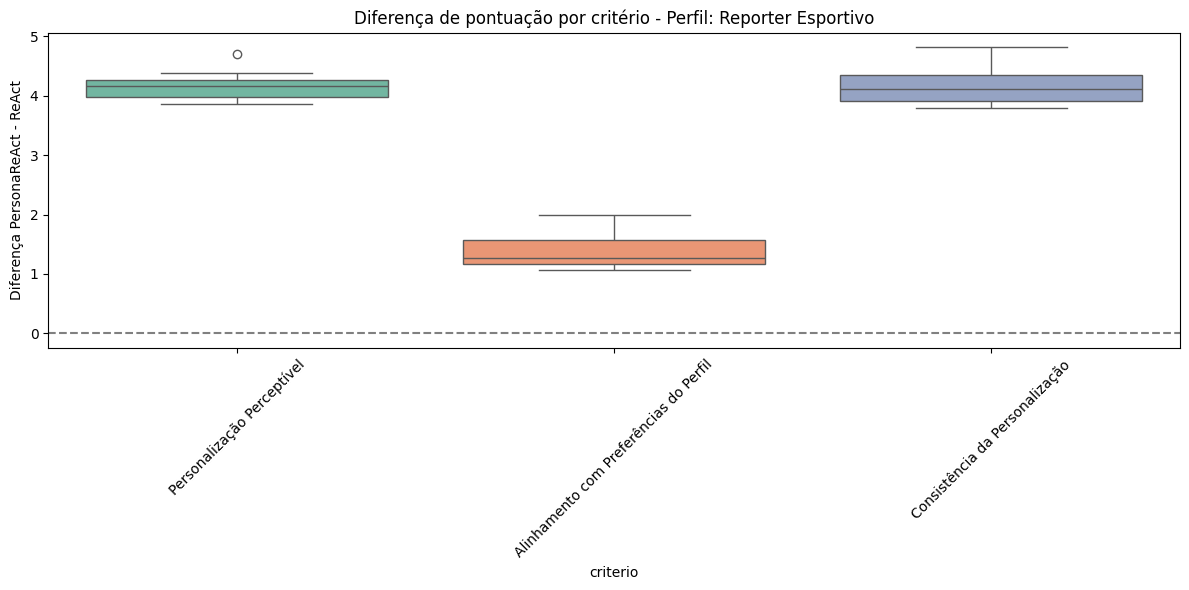

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Reporter Esportivo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

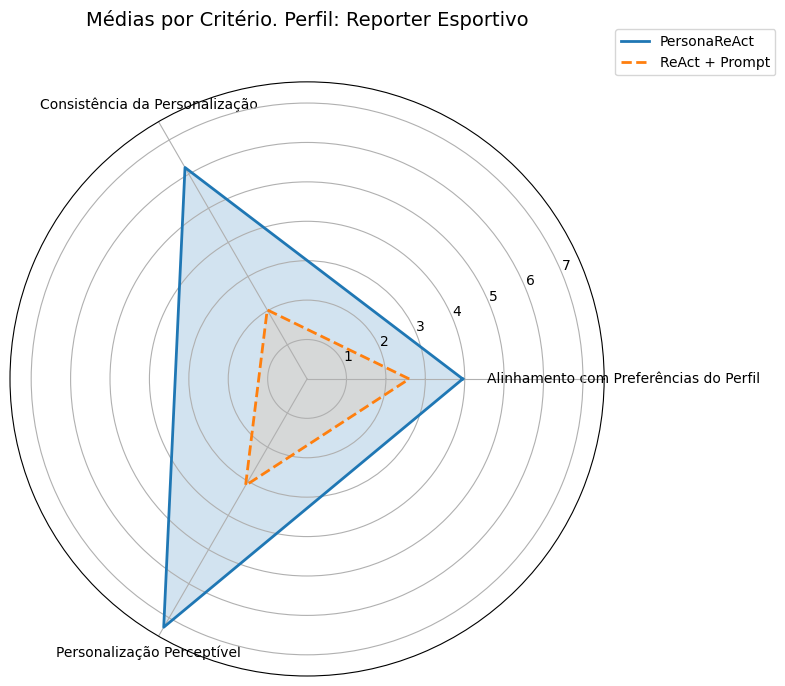

In [38]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Reporter Esportivo", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()